In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import ticker
import numpy as np
from matplotlib import colors
import util_small as util
from matplotlib.gridspec import GridSpec


In [4]:
run = "scream_dp_RCE_SMALL_3km_test_bcu_aa"
run_dir = f"/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/{run}/run/"
# run_dir = "/glade/work/sturbeville/DPSCREAM_simulations/all_run_files/"
file = run_dir + f"{run}.eam.h0.2000-01-01-00000.nc"
qsmall=1e-8

In [5]:
print(file)

/glade/derecho/scratch/sturbeville/DPSCREAM_simulations/scream_dp_RCE_SMALL_3km_test_bcu_aa/run/scream_dp_RCE_SMALL_3km_test_bcu_aa.eam.h0.2000-01-01-00000.nc


# ICNC vs Rice - original

In [7]:
# load the data
ds = xr.open_dataset(file)[["T","CLDICE","NUMICE","Q","BCU","NUC"]].isel(time=slice(10,-1))
print(ds)
# ds = ds.isel(time=slice(-10*24,-1))
print("getting t<-40 and cldice>qsmall...")
ds = ds.where((ds["T"]<233.15)&(ds.CLDICE>qsmall))
print("calc Rice...")
x_array = util.calc_rice(ds.CLDICE, ds.NUMICE)
print("calc NI...")
y_array = util.calc_ni(ds.NUMICE, ds.Q, ds.lev*100, ds["T"])
print(x_array.shape, y_array.shape)


<xarray.Dataset> Size: 119MB
Dimensions:  (time: 30, lev: 128, ncol: 1296)
Coordinates:
  * lev      (lev) float64 1kB 2.58 3.23 3.88 4.597 ... 987.2 991.0 994.9 998.5
  * time     (time) object 240B 2000-01-03 12:00:00 ... 2000-01-10 18:00:00
Dimensions without coordinates: ncol
Data variables:
    T        (time, lev, ncol) float32 20MB ...
    CLDICE   (time, lev, ncol) float32 20MB ...
    NUMICE   (time, lev, ncol) float32 20MB ...
    Q        (time, lev, ncol) float32 20MB ...
    BCU      (time, lev, ncol) float32 20MB ...
    NUC      (time, lev, ncol) float32 20MB ...
Attributes: (12/19)
    ne:                30
    np:                4
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         1a788d1576
    product:           model-output
    ...                ...
    institution_id:    E3SM-Project
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-

(30, 128, 1296) (30, 128, 1296)
flattening...
(4976640,) (4976640,)
(411831,) (411831,)
4976640
0.08175596386316872 counts...plotting... 

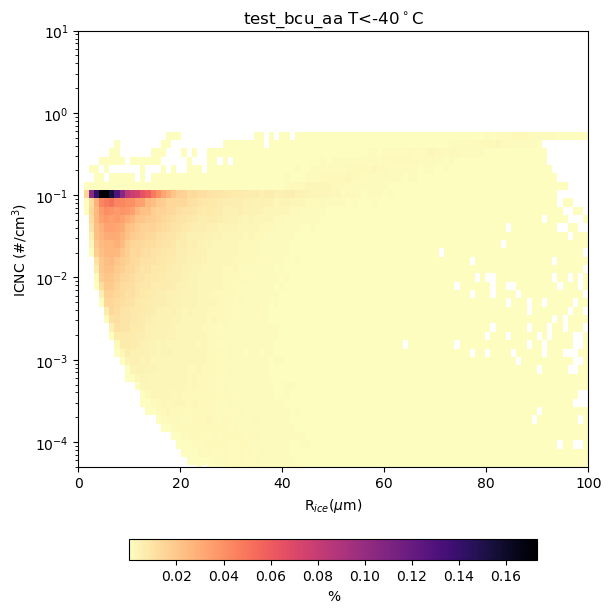

done


In [8]:
# plot it
ax = util.plot_microhist(x_array, y_array, savename="test_bcu_aa")

## conditional on BCU

In [17]:
nuc = -np.log(ds.NUC)

(30, 128, 1296) (30, 128, 1296)
flattening...
(4976640,) (4976640,)
(28429,) (28429,)
4976640
0.005712488747427984 counts...plotting... 

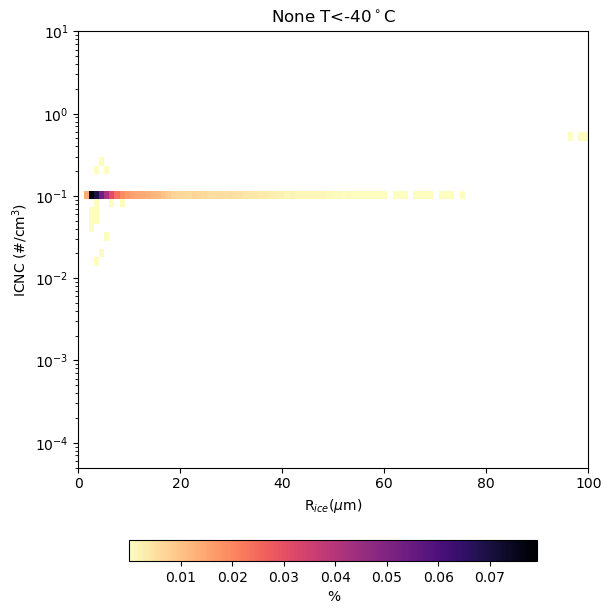

done


In [29]:
mask = ((nuc==0))
xarray = x_array.where(mask)
yarray = y_array.where(mask)
ax = util.plot_microhist(xarray, yarray)

# Cross section

In [20]:
t=4
chunks = {"x": 2000, "ncol": 2000}

ds = xr.open_dataset(file, chunks=chunks)[["crm_grid_x", "crm_grid_y", "CLDICE", "CLDLIQ", "Z3", "BCU", "NUC"]].isel(
    time=t
)  # .isel(time=slice(-20,-1))
x = ds.crm_grid_x
y = ds.crm_grid_y
iwc = ds.CLDICE+ds.CLDLIQ
iwc.shape

(128, 1296)

In [21]:
z = ds.Z3.mean(dim=["ncol"])
z.shape

(128,)

In [22]:
nuc = -np.log(ds.NUC)
bcu = -np.log(ds.BCU)

In [16]:
cross_mask = np.where(x < 10, 1, 0)
print(cross_mask.shape)
x0 = x.where(cross_mask)
y0 = y.where(cross_mask)
print(x0.shape, y0.shape)
ncross = np.nansum(cross_mask)
print(ncross)

(1296,)
(1296,) (1296,)
36


In [17]:
iwc_plot = iwc.where(cross_mask[np.newaxis, :])
nuc_plot = nuc.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
bcu_plot = bcu.where((iwc>qsmall)&(cross_mask[np.newaxis, :]))
# cld_plot = (
#     xr.where(bcu_plot>=2,1,0) +
#     xr.where(nuc_plot<(bcu_plot-5),2,0) +
#     xr.where(nuc_plot<(bcu_plot-24),1,0) +
#     xr.where((bcu_plot<nuc_plot)&(bcu_plot>=2),4,0)
# )
# cld_plot = cld_plot.where(temp<233.15)
# cld_plot

In [18]:
y.shape, z.shape, iwc_plot.shape, nuc_plot.shape, bcu_plot.shape#, cld_plot.shape

((1296,), (128,), (128, 1296), (128, 1296), (128, 1296))

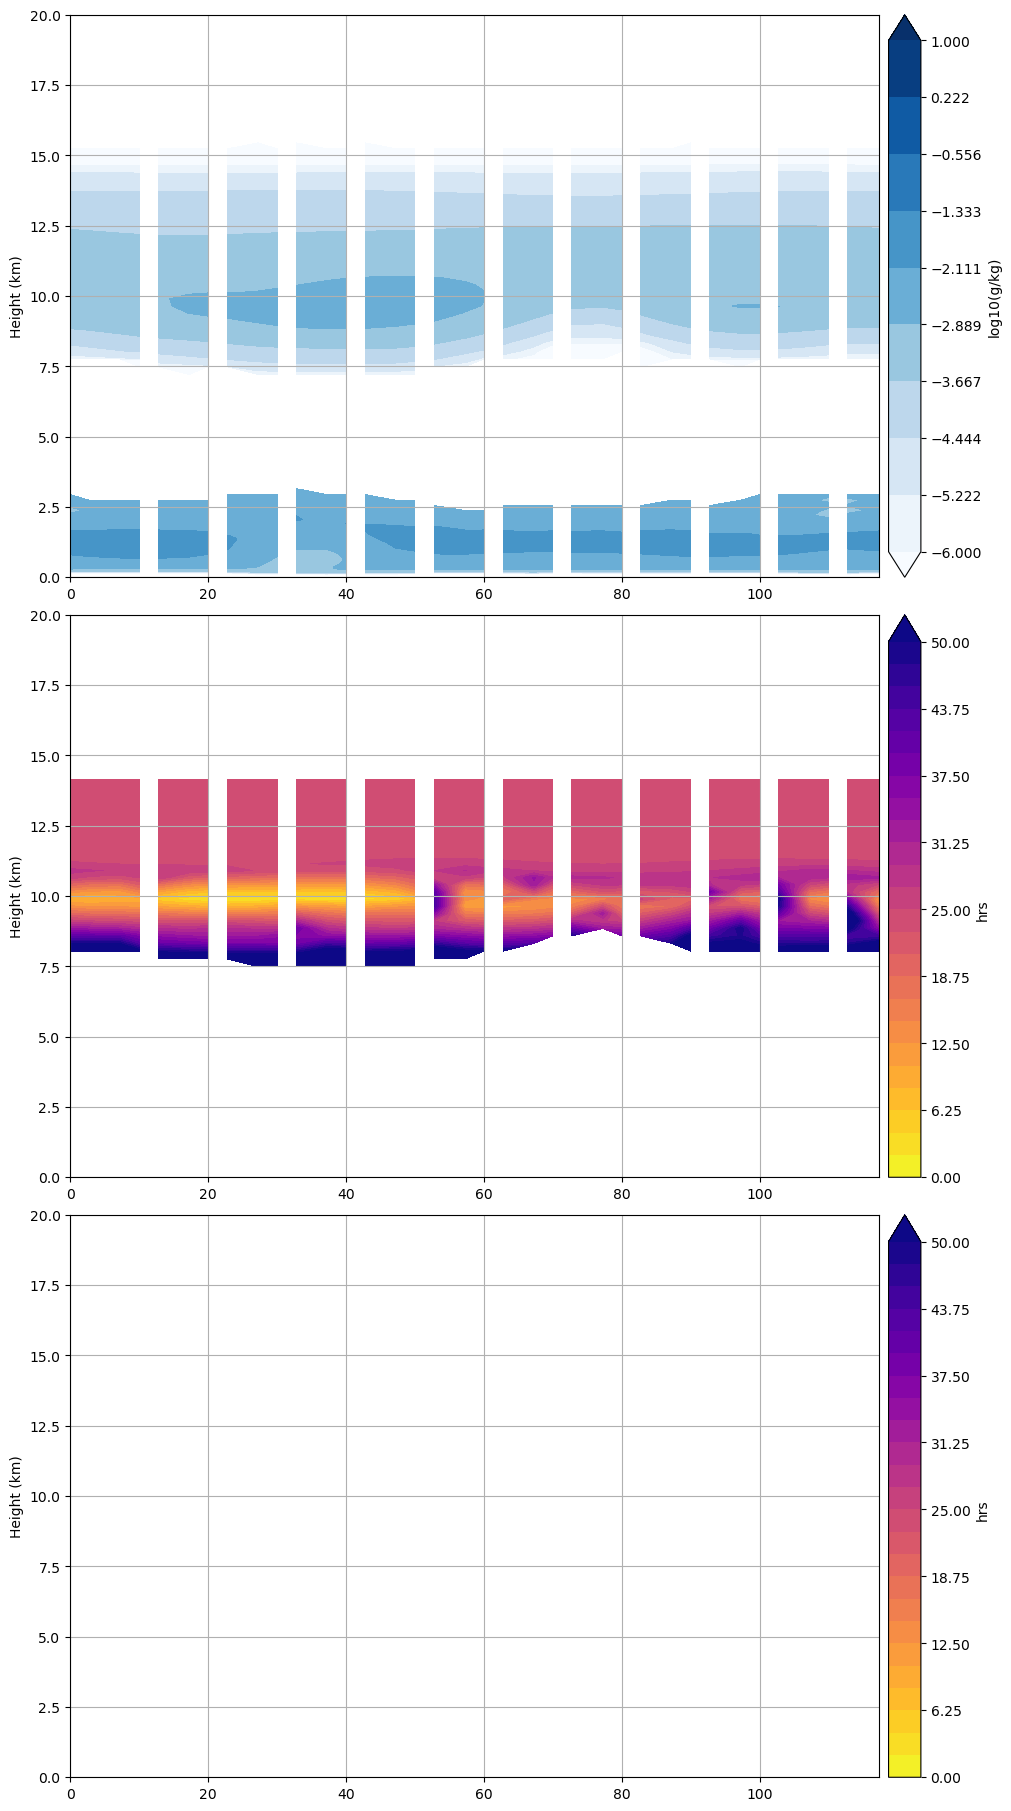

In [19]:
fig = plt.figure(figsize=(10, 18), layout="constrained")
gs = GridSpec(3, 2, figure=fig, width_ratios=[100, 4], hspace=0)
ax0 = fig.add_subplot(gs[0, 0])
cax0 = fig.add_subplot(gs[0, 1])
cf = ax0.contourf(
    y / 1000,
    z / 1000,
    np.log10(iwc_plot * 1000),
    levels=np.linspace(-6, 1, 10),
    extend="both",
    cmap="Blues",
)
plt.colorbar(cf, cax=cax0, label="log10(g/kg)")
ax1 = fig.add_subplot(gs[1, 0])
cax1 = fig.add_subplot(gs[1, 1])
cf = ax1.contourf(
    y / 1000,
    z / 1000,
    nuc_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax1, label="hrs")
ax2 = fig.add_subplot(gs[2, 0])
cax2 = fig.add_subplot(gs[2, 1])
cf = ax2.contourf(
    y / 1000,
    z / 1000,
    bcu_plot,
    levels=np.linspace(0, 50, 25),
    extend="max",
    cmap="plasma_r",
)
plt.colorbar(cf, cax=cax2, label="hrs")
# ax3 = fig.add_subplot(gs[3, 0])
# cax3 = fig.add_subplot(gs[3, 1])
# cf = ax3.contourf(
#     y / 1000,
#     z / 1000,
#     cld_plot,
#     levels=np.arange(0.5, 4.6, 1),
#     # extend="max",
#     cmap="rainbow",
# )
# cbar = plt.colorbar(cf, cax=cax3, ticks=[1,2,3,4])
# cbar.ax.set_yticklabels(["conv", "in-situ", "remote", "conv ci"])

ax0.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
ax1.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
ax2.set(ylim=[0, 20],  # xlim=[2000,3600],
        ylabel="Height (km)")
# ax3.set(ylim=[0, 20],  # xlim=[2000,3600],
#         ylabel="Height (km)", xlabel="x (km)")
ax0.grid(True)
ax1.grid(True)
ax2.grid(True)
# ax3.grid(True)
plt.savefig(f"../plots/small/cross_section_nucltbcu-5_{run}_{t:04d}.png")
plt.show()

# IWP percentile vs IWC, bcu, and nuc

In [109]:
ds = xr.open_dataset(file, chunks=chunks)[["crm_grid_x", "crm_grid_y", "CLDICE", "Z3", "BCU", "NUC","TGCLDCWP"]]
# .isel(
#     time=t
# )  # .isel(time=slice(-20,-1))
x = ds.crm_grid_x
y = ds.crm_grid_y
iwp = ds.TGCLDCWP
iwc = ds.CLDICE
bcu = -np.log(ds.BCU)
nuc = -np.log(ds.NUC)
z_mean = ds.Z3.mean(dim=['time','ncol'])/1000
print(iwp.shape, iwc.shape, z_mean.shape)

(13, 1296) (13, 128, 1296) (128,)


In [97]:
percs = np.arange(5, 100.1, 10)
iwp_percs = np.nanpercentile(iwp, percs)
dict(zip(percs,iwp_percs))

{5.0: 5.747742193307204e-07,
 15.0: 0.0002466140853357501,
 25.0: 0.0008894080820027739,
 35.0: 0.0016638011438772076,
 45.0: 0.0039036479895003164,
 55.0: 0.006827304977923632,
 65.0: 0.011129747098311786,
 75.0: 0.020134183578193188,
 85.0: 0.048673731088638254,
 95.0: 0.31372000724077204}

In [99]:
percs.shape, iwc.shape, bcu.shape, nuc.shape

((10,), (13, 128, 1296), (13, 128, 1296), (13, 128, 1296))

In [100]:
iwc_by_iwp = np.zeros((len(percs), len(z_mean)))
bcu_by_iwp = np.zeros((len(percs), len(z_mean)))
nuc_by_iwp = np.zeros((len(percs), len(z_mean)))

print(iwc_by_iwp.shape, percs.shape, iwc.shape)
for i in range(len(percs)-1):
    iwc_by_iwp[i,:] = np.nanmean(iwc.where((iwp>iwp_percs[i])&(iwp<=iwp_percs[i+1])), axis=(0,2))
    bcu_by_iwp[i,:] = np.nanmean(bcu.where((iwp>iwp_percs[i])&(iwp<=iwp_percs[i+1])), axis=(0,2))
    nuc_by_iwp[i,:] = np.nanmean(nuc.where((iwp>iwp_percs[i])&(iwp<=iwp_percs[i+1])), axis=(0,2))
iwc_by_iwp[-1,:] =  np.nanmean(iwc.where((iwp>iwp_percs[-1])), axis=(0,2))
bcu_by_iwp[-1,:] =  np.nanmean(bcu.where((iwp>iwp_percs[-1])), axis=(0,2))
nuc_by_iwp[-1,:] =  np.nanmean(nuc.where((iwp>iwp_percs[-1])), axis=(0,2))

(10, 128) (10,) (13, 128, 1296)


In [101]:
iwc_by_iwp.shape, percs.shape

((10, 128), (10,))

/glade/derecho/scratch/sturbeville/tmp/ipykernel_40363/2317118549.py:2: RuntimeWarning: divide by zero encountered in log10
  cs = ax.pcolormesh(percs, z_mean, np.log10(iwc_by_iwp.T*1000), vmin=-7, vmax=0, cmap="Blues")


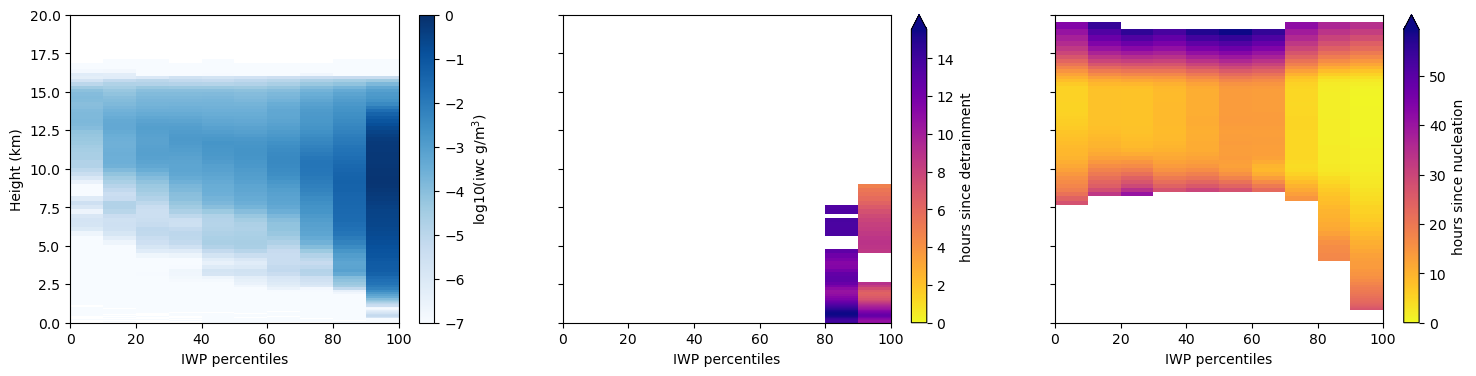

In [112]:
fig, [ax, axb, axn] = plt.subplots(1,3, figsize=(18,4), sharey=True)
cs = ax.pcolormesh(percs, z_mean, np.log10(iwc_by_iwp.T*1000), vmin=-7, vmax=0, cmap="Blues")
plt.colorbar(cs, ax=ax, label="log10(iwc g/m$^3$)")
ax.set(ylim=[0,20])
ax.set(xlabel="IWP percentiles", ylabel="Height (km)")

cs = axb.pcolormesh(percs, z_mean, bcu_by_iwp.T, cmap="plasma_r", vmin=0)
plt.colorbar(cs, ax=axb, label="hours since detrainment", extend="max")
axb.set(ylim=[0,20])
axb.set(xlabel="IWP percentiles")

cs = axn.pcolormesh(percs, z_mean, nuc_by_iwp.T, cmap="plasma_r", vmin=0)
plt.colorbar(cs, ax=axn, label="hours since nucleation", extend="max")
axn.set(ylim=[0,20])
axn.set(xlabel="IWP percentiles")

plt.show()

# misc

In [115]:
iwc.where(bcu>5).mean().values

array(9.912613e-07, dtype=float32)

(array([ 4537.,  5817., 10635., 16429., 22085., 25312., 28507., 28907.,
        31111., 35759., 43014., 47510., 51651., 50463., 48565., 47009.,
        45090., 45035., 43572., 39620., 35570., 33070., 30615., 27917.,
        25100., 22036., 18888., 16260., 14332., 13039., 11587., 10663.,
         9796.,  9202.,  8585.,  7983.,  7170.,  6847.,  6403.,  5900.,
         5675.,  5368.,  5345.,  4952.,  4750.,  4564.,  4409.]),
 array([ 0.        ,  1.0212766 ,  2.04255319,  3.06382979,  4.08510638,
         5.10638298,  6.12765957,  7.14893617,  8.17021277,  9.19148936,
        10.21276596, 11.23404255, 12.25531915, 13.27659574, 14.29787234,
        15.31914894, 16.34042553, 17.36170213, 18.38297872, 19.40425532,
        20.42553191, 21.44680851, 22.46808511, 23.4893617 , 24.5106383 ,
        25.53191489, 26.55319149, 27.57446809, 28.59574468, 29.61702128,
        30.63829787, 31.65957447, 32.68085106, 33.70212766, 34.72340426,
        35.74468085, 36.76595745, 37.78723404, 38.80851064, 39.

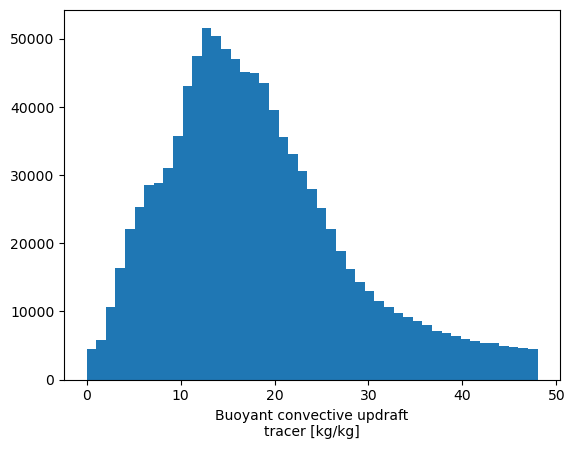

In [120]:
bcu.plot.hist(bins=np.linspace(0,48,48))